## Object Detection Model training using YOLO
References - 
- [Documentation](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#13-prepare-dataset-for-yolov5)
- [Testing IoU](https://stackoverflow.com/questions/77565416/how-to-test-iou-score-after-training-a-yolo-model)
- [IoU calculation](https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation)
- [Hungarian Algorithm to match Bounding Boxes](https://gist.github.com/AruniRC/c629c2df0e68e23aff7dcaeef87c72d4)

In [13]:
# Import necessary libraries
import numpy as np
import os, sys 
import matplotlib.pyplot as plt
from ultralytics import YOLO
import fiftyone as fo 
import fiftyone.zoo as foz
from fiftyone import ViewField as F
import json, shutil 
from collections import defaultdict
from itertools import product 
from functools import reduce
from scipy.optimize import linear_sum_assignment
import cv2

np.random.seed(0)
# Save to current directory
curr_dir = os.getcwd()

In [2]:
# Parameters
train_test_split = 0.8
num_epochs = 10

In [ ]:
# Load dataset
fo.config.dataset_zoo_dir = curr_dir

# Download the data
# By default, the following loads data for detections
dataset = foz.load_zoo_dataset("coco-2017", 
                            splits=['train'],
                            shuffle=True,
                            seed=0,
                            label_types=['detections'],
                            only_matching=True,
                            classes=['person'])

In [4]:
# Load the downloaded dataset
coco_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path='coco-2017/train/data',
    labels_path='coco-2017/train/labels.json',
    include_id=True,
)

 100% |███████████████| 5000/5000 [1.3m elapsed, 0s remaining, 71.0 samples/s]      


In [ ]:
# The above downloads all classes in COCO
# We filter them to only have people using the following - 
coco_dataset.export(
    labels_path="coco-2017/labels.json",
    dataset_type=fo.types.COCODetectionDataset,
    classes=['person'],
)

In [6]:
# We need to convert the dataset to YOLO format
input_dir = curr_dir + "/coco-2017/"
output_dir = curr_dir + "/yolo/"

images_folder = input_dir + "train/data/"

if not os.path.exists(output_dir):
	os.mkdir(output_dir)

for split in ['train', 'test']:
	shutil.rmtree(output_dir + split, ignore_errors=True)
	os.mkdir(output_dir + split)
	os.mkdir(output_dir + split + '/images')
	os.mkdir(output_dir + split + '/labels')

In [7]:

ground_truths = defaultdict(list)

# Read the annotations
with open(input_dir + 'labels.json', 'r') as f:
		data = json.load(f)

# Count number of annotations
num_data = len(data['images'])

# Choose 80-20 split
num_train = np.floor(train_test_split*num_data)
num_test = np.floor((1 - train_test_split)*num_data)

# Match annotations to images and write in YOLO format
count = 0

id_ann = defaultdict(list)
for ann in data['annotations']:
	id_ann[ann['image_id']].append(ann)

for image in data['images']:
	width = image['width']
	height = image['height']
	filename = image['file_name'].split('.')[0]
	id = image['id']

	
	# Writing current object and copying image
	if count < num_train:
		split = 'train'
	else:
		split = 'test'
	
	f = open(f'{output_dir}{split}/labels/{filename}.txt', 'w')

	for annotation in id_ann[id]:
		current_category = annotation['category_id']
		x, y, w, h = annotation['bbox']
		
		# Finding midpoints
		x_centre = x + w/2
		y_centre = y + h/2
		
		# Normalization
		x_centre /= width
		y_centre /= height
		w /= width
		h /= height
		
		# Limiting upto fix number of decimal places
		sx_centre = format(x_centre, '.6f')
		sy_centre = format(y_centre, '.6f')
		sw = format(w, '.6f')
		sh = format(h, '.6f')


		ground_truths[image['file_name']].append([x_centre, y_centre, w, h])
		
		# Write annotations to file
		f.write(f"{current_category} {sx_centre} {sy_centre} {sw} {sh}\n")
	f.close()
	shutil.copy(images_folder + image['file_name'], f'{output_dir}{split}/images/{filename}.jpg')	
	count += 1


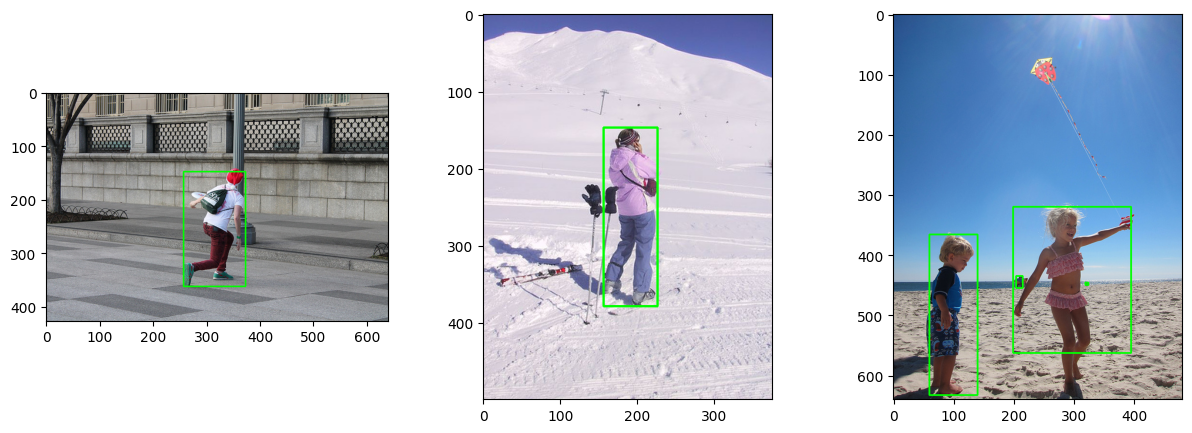

In [43]:
# Sample an image from the dataset for credibility
train_images = os.listdir(images_folder)
random_images = np.random.choice(train_images, 3)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, file in enumerate(random_images):
    img = cv2.imread(images_folder + file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    anns = ground_truths[file]
    for ann in anns:
        start = (int((ann[0] - ann[2]/2)*w), int((ann[1] - ann[3]/2)*h))
        end = (int((ann[0] + ann[2]/2)*w), int((ann[1] + ann[3]/2)*h))
        img = cv2.rectangle(img, start, end, (0, 255, 0), 2)
    ax[i].imshow(img)

In [87]:
# Load untrained model for training
# We imported YOLO from ultralytics
model = YOLO('yolov5nu.pt')

In [ ]:
# Train the model
# Device = mps is for Apple Silicon
train_results = model.train(data='config.yaml', batch=16, epochs=num_epochs, plots=True, device='mps')

In [ ]:
# Save the model
model.save(filename='trained.pt')

In [88]:
# Load model from trained weights
model.load('trained.pt')

Transferred 427/427 items from pretrained weights


In [10]:
# Function to calculate the IoU score given two normalized bounding boxes as input
def calc_iou(bb1, bb2):
    b1_x1 = bb1[0] - bb1[2]/2
    b1_x2 = bb1[0] + bb1[2]/2
    b1_y1 = bb1[1] - bb1[3]/2
    b1_y2 = bb1[1] + bb1[3]/2

    b2_x1 = bb2[0] - bb2[2]/2
    b2_x2 = bb2[0] + bb2[2]/2
    b2_y1 = bb2[1] - bb2[3]/2
    b2_y2 = bb2[1] + bb2[3]/2

    # determine the coordinates of the intersection rectangle
    x_left = max(b1_x1, b2_x1)
    y_top = max(b1_y1, b2_y1)
    x_right = min(b1_x2, b2_x2)
    y_bottom = min(b1_y2, b2_y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = bb1[2]*bb1[3]
    bb2_area = bb2[2]*bb2[3]

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
# Test the data with IOU score 
test_images_folder = output_dir + 'test/images/'
test_labels_folder = output_dir + 'test/labels'
test_files = os.listdir(test_images_folder)
sum_iou = 0
ious = defaultdict(float)
num_test = len(test_files)

# Create a folder to save the results
results_folder = output_dir + 'results/'
if not os.path.exists(results_folder):
	os.mkdir(results_folder)
    
# Iterate through the test files to test the performance
for test_file in test_files:
    res = model.predict(test_images_folder + test_file, classes=[0])
    res[0].save(results_folder + test_file)
    
    gt = ground_truths[test_file]
    preds = res[0].boxes.xywhn.numpy()
    
    if len(gt) == 0 or len(preds) == 0:
         continue
    
    combinations = list(product(gt, preds))
    iou_matrix = np.zeros((len(gt), len(preds)))
    for i in range(len(gt)):
        for j in range(len(preds)):
            iou_matrix[i, j] = calc_iou(gt[i], preds[j])

    # Do the Hungarian matching algorithm
    gt_idx, pred_idx = linear_sum_assignment(1 - iou_matrix)
    assigned_ious = np.sort(iou_matrix[gt_idx, pred_idx])[-len(gt):]
    
    # Compute mean across all instances in the image
    mean_iou = np.mean(assigned_ious)

    assert mean_iou <= 1.0 
    
    sum_iou += mean_iou
    ious[test_file] = (mean_iou, assigned_ious)

In [92]:
# Calculate the mean across all test cases
print("The average IoU across all test instances is", sum_iou/num_test)

The average IoU across all test instances is 0.7619198520725794



image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000561795.jpg: 480x640 2 persons, 72.6ms
Speed: 1.4ms preprocess, 72.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000503008.jpg: 448x640 1 person, 58.3ms
Speed: 1.0ms preprocess, 58.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


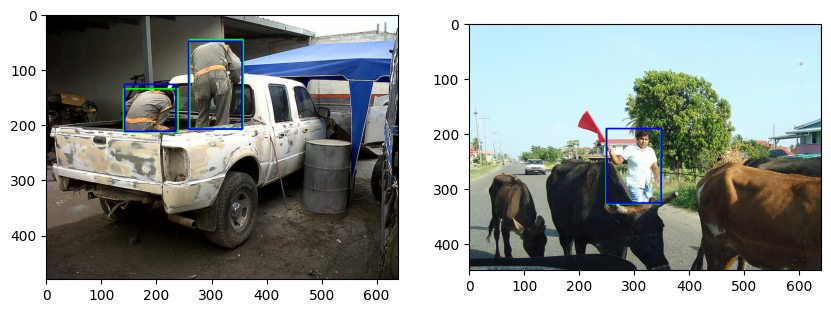

In [93]:
# Show some sample output results
n_samples = 2
random_tests = np.random.choice(test_files, n_samples)

fig, ax = plt.subplots(1, n_samples, figsize=(n_samples*5, 5))

for i, test_file in enumerate(random_tests):
    res = model.predict(test_images_folder + test_file, classes=[0])
    preds = res[0].boxes.xywhn.numpy()
    img = cv2.imread(test_images_folder + test_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    anns = ground_truths[test_file]
    for ann in anns:
        start = (int((ann[0] - ann[2]/2)*w), int((ann[1] - ann[3]/2)*h))
        end = (int((ann[0] + ann[2]/2)*w), int((ann[1] + ann[3]/2)*h))
        img = cv2.rectangle(img, start, end, (0, 255, 0), 2)
    
    for ann in preds:
        start = (int((ann[0] - ann[2]/2)*w), int((ann[1] - ann[3]/2)*h))
        end = (int((ann[0] + ann[2]/2)*w), int((ann[1] + ann[3]/2)*h))
        img = cv2.rectangle(img, start, end, (0, 0, 255), 2)

    ax[i].imshow(img)